In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-doodles/translations.csv
/kaggle/input/google-doodles/list.csv


In [2]:
from torch import nn
import math
import torch
import torch.nn.functional as F
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from IPython.display import clear_output
import numpy as np 
from PIL import Image
from io import BytesIO
# from StringIO import StringIO
import urllib.request
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm

In [3]:
data = pd.read_csv("/kaggle/input/google-doodles/list.csv")
data.head(5)

,year,month,day,name,title,query,share_text,url,alternate_url,high_res_url,high_res_width,high_res_height
0,1999,10,31,halloween-1999,Halloween 1999,Halloween 1999,Halloween 1999 #GoogleDoodle,//www.google.com/logos/1999/googlepump.gif,NaN,//www.google.com/logos/1999/googlepump.gif,306.0,130.0
1,1999,11,23,thanksgiving-1999,Thanksgiving 1999,Thanksgiving 1999,Thanksgiving 1999 #GoogleDoodle,//www.google.com/logos/1999/turkey_home2.gif,NaN,//www.google.com/logos/1999/turkey_home2.gif,276.0,128.0
2,1999,11,30,uncle-sam-search-1,'Uncle Sam' Search #1,'Uncle Sam' Search #1,'Uncle Sam' Search #1 #GoogleDoodle,//www.google.com/logos/1999/unclesam2.gif,NaN,//www.google.com/logos/1999/unclesam2.gif,291.0,102.0
3,1999,11,30,uncle-sam-search-2,'Uncle Sam' Search #2,'Uncle Sam' Search #2,'Uncle Sam' Search #2 #GoogleDoodle,//www.google.com/logos/1999/unclesam.gif,NaN,//www.google.com/logos/1999/unclesam.gif,291.0,102.0
4,1999,12,25,happy-holidays-from-google-1999,Happy Holidays from Google 1999,Happy Holidays from Google 1999,Happy Holidays from Google 1999 #GoogleDoodle,//www.google.com/logos/1999/snowmanC.gif,NaN,//www.google.com/logos/1999/snowmanC.gif,338.0,121.0


In [4]:
data["url"][100]

'//www.google.com/logos/2002/halloween02.gif'

In [5]:
# import os
# os.mkdir("doodles")

In [6]:

# for i in range(len(data["url"])):
#     res = requests.get("https:"+data["url"][i])
#     with open("doodles/img"+str(i)+".jpg", "wb") as f:
#         f.write(res.content)

In [7]:
# import shutil
# shutil.make_archive("google_doodle", 'zip', "/kaggle/working/doodles")

In [8]:
# from IPython.display import FileLink
# FileLink(r'google_doodle.zip')

In [9]:
# import matplotlib.pyplot as plt
# sample_index = 400
# img = plt.imread("/kaggle/working/img"+str(sample_index)+".jpg")
# print(img.shape)
# plt.imshow(img)
# print(data["name"][sample_index])

In [10]:
image_url = "https:"+ data["url"][400]
res = requests.get(image_url)
content = res.content
img = Image.open(BytesIO(content))
img.save("test.png")

In [11]:
class Dataset(Dataset):
    def __init__(self,df,transform_img=None):
        self.url_df = df["url"]
        self.propmt_df = df["name"]
        self.transform_img = transform_img
    def __len__(self):
        return len(self.url_df)
    def __getitem__(self,i):
        image_url = "https:"+ self.url_df[i]
        propmt = self.propmt_df[i]
        res = requests.get(image_url)
        content = res.content
        img = Image.open(BytesIO(content))
#         img = Image.open(urllib.request.urlretrieve(image_url))
#         print(img.size)
        if self.transform_img:
            img = self.transform_img(img)
        return img , propmt

BATCH_SIZE = 128
transformationImage = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((64,128)),
#         transforms.RandomHorizontalFlip(),
         # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1),
        
    ]
)

In [12]:
train_data = Dataset(data[:1500],transform_img=transformationImage)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

4th-of-july-2000-3


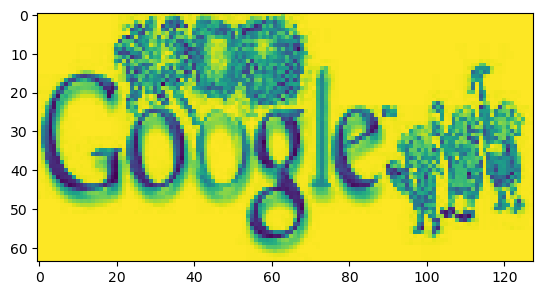

In [35]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))
image , text = train_data[19]    
show_tensor_image(image)
# print(train_data[100].shape)
print(text)

In [14]:
!pip install git+https://github.com/openai/CLIP

  Cloning https://github.com/openai/CLIP to /tmp/pip-req-build-ymyg4p9z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP /tmp/pip-req-build-ymyg4p9z
  Resolved https://github.com/openai/CLIP to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=ea80c999571bb4b7ba52c7b064c74a1938e2bb7d97684eb6909ff9be6e267993
  Stored in directory: /tmp/pip-ephem-wheel-cache-zmm6j67u/wheels/36/0a/8d/9c006e33df19ef5d1b82819d99d1cb643f29f04ac39464094a
Successfully built clip


In [15]:
import clip
propmt = "happy-holidays-from-google-2007-5"
clip_model = "ViT-B/32"
device = "cuda"
clip_model = clip.load(clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
# emb = clip_model.encode_text(clip.tokenize(propmt)).to(device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 206MiB/s]


In [16]:
# U-Net model for Backward Diffusion process

class Block(nn.Module):
    def __init__(self,in_ch,out_ch,time_emb_dim,text_dim,up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim,out_ch)
        self.text_mlp = nn.Linear(text_dim,out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch,out_ch,3,padding=1)
            self.transform = nn.ConvTranspose2d(out_ch,out_ch,4,2,1)
        else:
            self.conv1 = nn.Conv2d(in_ch,out_ch,3,padding=1)
            self.transform = nn.Conv2d(out_ch,out_ch,4,2,1)
        self.conv2 = nn.Conv2d(out_ch,out_ch,3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    def forward(self,x,t,s):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        text_emb = self.relu(self.text_mlp(s))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        text_emb = text_emb[(..., ) + (None, ) * 2]
        h=h+time_emb+text_emb
        h=self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)
        

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
#         print(embeddings.shape)
        return embeddings

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128,256,512,1024)
        up_channels = (1024,512,256,128, 64)
        out_dim = 1 
        time_emb_dim = 32
        text_emb_dim = 512

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim,text_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim,text_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x, timestep,text):
        # Embedd time
        t = self.time_mlp(timestep)
        s = clip_model.encode_text(clip.tokenize(text).to(device))
        s = s.to(torch.float32)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
#             print(x.shape,"down")
#             print(s)
            x = down(x, t,s)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
#             print(x.shape,"up")
#             print(residual_x.shape,"up")
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t,s)
        return self.output(x)
model = SimpleUnet()
model
# test = SinusoidalPositionEmbeddings(16).forward(torch.tensor([10]))
# layer = nn.Linear(16,64)
# test = layer(test)
# # test
# print(test.shape)
# test = test[(..., ) + (None, ) * 2]
# print(test.shape)





SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (text_mlp): Linear(in_features=512, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (text_mlp): Linear(in

In [17]:
T = 300
def beta_schedule(timestamps, start = 0.0001, end=0.02):
  return torch.linspace(start,end,timestamps)


betas = beta_schedule(timestamps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


def get_index_from_list(vals,t,x_shape):
  batch_size = t.shape[0]
  out = vals.gather(-1,t.cpu())
  return out.reshape(batch_size,*((1,)*(len(x_shape)-1))).to(t.device)

def forward_diffusion(x_0,t,device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


In [18]:

def get_loss(model,x_0,t,s):
    x_noisy,noise = forward_diffusion(x_0,t,device)
    noise_pred = model(x_noisy,t,s)
#     print(noise.shape)
#     print(noise_pred.shape)
#     return F.l1_loss(noise,noise_pred)
    return F.l1_loss(noise,noise_pred)



def show_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    return reverse_transforms(image)


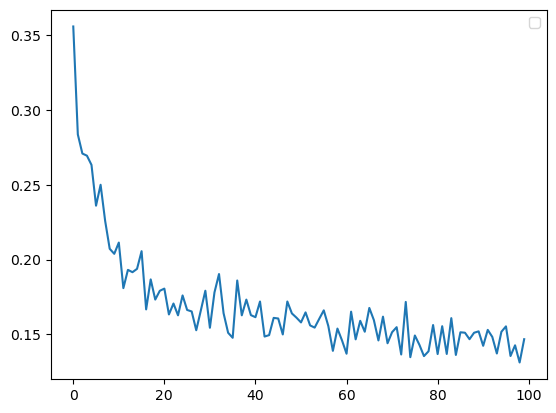

In [19]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(),lr=0.001)
epochs = 100
loss_values = []
for epoch in range(epochs):
    for images,texts in tqdm(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0,T,(BATCH_SIZE,),device=device).long()
        loss = get_loss(model,images,t,texts)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    clear_output(wait = True)
    plt.plot(loss_values)
    plt.legend()
    plt.show()

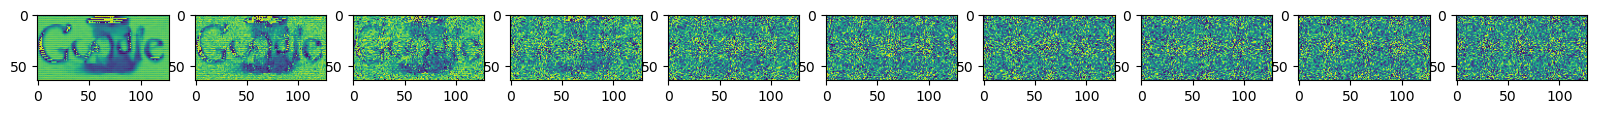

In [42]:

@torch.no_grad()
def sample_timestep(x, t,s):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
#     print(x.shape)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t,s) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
@torch.no_grad()
def sample_plot_image():
    # Sample noise
#     img_size = IMG_SIZE
    img = torch.randn((1,1 , 64, 128), device=device)
    plt.figure(figsize=(20,20))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, "world cup")
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()  

sample_plot_image()


In [21]:
@torch.no_grad()
def generate_image():
    # Sample noise
    img_size = IMG_SIZE
    
    fix,ax = plt.subplots(3,3,figsize=(15,15))
#     plt.figure(figsize=(25,25))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    for h in range(3):
        for p in range(3):
            img = torch.randn((1,3 , img_size, img_size), device=device)
            for i in range(0,T)[::-1]:
                t = torch.full((1,), i, device=device, dtype=torch.long)
                img = sample_timestep(img, t)
                if i == 0:
        #             plt.subplot(1, num_images, int(i/stepsize)+1)

                    ax[h][p].imshow(show_image(img.detach().cpu()))
        #     plt.show() 
